In [15]:
import numpy as np 
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as colormap
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


In [16]:
train_dir = '/kaggle/input/finaldataset/Datasets/AffectNetHQ/train/'
val_dir = '/kaggle/input/finaldataset/Datasets/AffectNetHQ/validation/'
test_dir ='/kaggle/input/finaldataset/Datasets/AffectNetHQ/test/'

train_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
val_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(val_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
test_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_dir) for f in filenames if f.endswith(('.jpg', '.png'))]

print('train_images:',len(train_images))
print('val_images:',len(val_images))
print('test_images:',len(test_images))


train_images: 6400
val_images: 1600
test_images: 2000


In [17]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Resize((224, 224))
    ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224))
    ])

class dataset(Dataset):
    def __init__(self, images_dir, transform, device):
        self.images_dir = images_dir
        self.transform = transform
        self.device = device
        self.class_names = sorted(os.listdir(self.images_dir))
        self.image_paths = []
        self.labels = []
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.images_dir, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(i)
        self.device = device
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(image_path)
        image = self.transform(image).to(self.device)
        label = torch.LongTensor([label]).to(self.device)
        return image, label

In [18]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
torch.cuda.empty_cache()

train_data = dataset(train_dir, train_transforms, device)
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)

val_data = dataset(val_dir, train_transforms, device)
val_loader = DataLoader(val_data, batch_size = 128, shuffle = True)

test_data = dataset(test_dir, test_transforms, device)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

In [19]:
def plot_data_loader(data_loader, gridDims, class_names):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, labels = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
            axes[i, j].set_title(class_names[labels[0]])
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

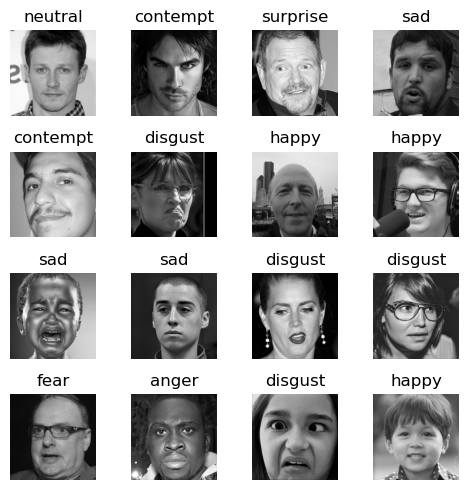

In [20]:
plot_data_loader(train_loader, (4, 4), train_data.class_names)

In [21]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        labels = labels.reshape(-1)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

In [22]:
def val_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc

In [23]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_labelsForProbs = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labelsForProbs.append(labels.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds += preds.cpu().numpy().tolist()
            all_labels += labels.cpu().numpy().tolist()
    all_probs = np.concatenate(all_probs)
    all_labelsForProbs = np.concatenate(all_labelsForProbs)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    epoch_classification_report = classification_report(all_labels, all_preds)
    print(f'Test Results:')
    print(f'Test Accuracy: {epoch_acc:.4f}')
    print(f'\n{epoch_classification_report}')
    cm = confusion_matrix(all_labels, all_preds)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=train_data.class_names, yticklabels=test_data.class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    n_classes = len(test_data.class_names)
    y_test = label_binarize(all_labelsForProbs, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], all_probs[:, i], average='macro')
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), all_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, all_probs, average="micro")
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
    label_names = test_data.class_names
    cmap = colormap.get_cmap('tab20',len(label_names))
    colors = [cmap(i) for i in range(len(label_names))]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'{test_data.class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [24]:
import torchvision.models as models
model = models.resnet18(pretrained=False)
#num_ftrs = model.classifier[1].in_features
#model.classifier = nn.Linear(num_ftrs, len(train_data.class_names))
model.fc = torch.nn.Linear(model.fc.in_features, len(train_data.class_names))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)
print("Device: {}".format(device))

Device: cuda


In [25]:
num_epochs = 25
patience = 7
best_acc = 0  
best_model = None

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = val_model(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
  
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0  
        best_model = model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 1/25 | Train Loss: 1.7571 | Train Acc: 0.2798 | Val Loss: 1.3639 | Val Acc: 0.2637


100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


Epoch 2/25 | Train Loss: 1.4456 | Train Acc: 0.4192 | Val Loss: 1.8949 | Val Acc: 0.2737


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 3/25 | Train Loss: 1.2970 | Train Acc: 0.4802 | Val Loss: 1.2322 | Val Acc: 0.4219


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 4/25 | Train Loss: 1.2062 | Train Acc: 0.5277 | Val Loss: 1.9273 | Val Acc: 0.2981


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 5/25 | Train Loss: 1.1213 | Train Acc: 0.5695 | Val Loss: 1.2188 | Val Acc: 0.4306


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Epoch 6/25 | Train Loss: 1.0441 | Train Acc: 0.5945 | Val Loss: 1.1035 | Val Acc: 0.4900


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 7/25 | Train Loss: 0.9786 | Train Acc: 0.6330 | Val Loss: 1.2934 | Val Acc: 0.4456


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Epoch 8/25 | Train Loss: 0.9107 | Train Acc: 0.6594 | Val Loss: 1.0926 | Val Acc: 0.4869


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 9/25 | Train Loss: 0.8195 | Train Acc: 0.6930 | Val Loss: 1.2268 | Val Acc: 0.5056


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 10/25 | Train Loss: 0.7353 | Train Acc: 0.7298 | Val Loss: 1.2550 | Val Acc: 0.5081


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 11/25 | Train Loss: 0.6349 | Train Acc: 0.7716 | Val Loss: 1.3668 | Val Acc: 0.4713


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 12/25 | Train Loss: 0.5645 | Train Acc: 0.7975 | Val Loss: 1.6073 | Val Acc: 0.4275


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 13/25 | Train Loss: 0.4638 | Train Acc: 0.8339 | Val Loss: 1.2881 | Val Acc: 0.5219


100%|██████████| 13/13 [00:05<00:00,  2.29it/s]


Epoch 14/25 | Train Loss: 0.3851 | Train Acc: 0.8653 | Val Loss: 1.4803 | Val Acc: 0.5094


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 15/25 | Train Loss: 0.3071 | Train Acc: 0.8908 | Val Loss: 1.4850 | Val Acc: 0.5181


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


Epoch 16/25 | Train Loss: 0.2372 | Train Acc: 0.9225 | Val Loss: 1.3495 | Val Acc: 0.5363


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 17/25 | Train Loss: 0.2172 | Train Acc: 0.9291 | Val Loss: 1.8938 | Val Acc: 0.4662


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


Epoch 18/25 | Train Loss: 0.1691 | Train Acc: 0.9447 | Val Loss: 1.4690 | Val Acc: 0.5419


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 19/25 | Train Loss: 0.1332 | Train Acc: 0.9583 | Val Loss: 1.9779 | Val Acc: 0.4963


100%|██████████| 13/13 [00:05<00:00,  2.45it/s]


Epoch 20/25 | Train Loss: 0.1292 | Train Acc: 0.9600 | Val Loss: 1.6003 | Val Acc: 0.5463


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 21/25 | Train Loss: 0.1145 | Train Acc: 0.9658 | Val Loss: 1.9004 | Val Acc: 0.5281


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Epoch 22/25 | Train Loss: 0.0900 | Train Acc: 0.9731 | Val Loss: 1.7906 | Val Acc: 0.5325


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 23/25 | Train Loss: 0.0781 | Train Acc: 0.9764 | Val Loss: 1.8978 | Val Acc: 0.5494


100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 24/25 | Train Loss: 0.0695 | Train Acc: 0.9813 | Val Loss: 1.6823 | Val Acc: 0.5587


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]

Epoch 25/25 | Train Loss: 0.0710 | Train Acc: 0.9811 | Val Loss: 1.8884 | Val Acc: 0.5156


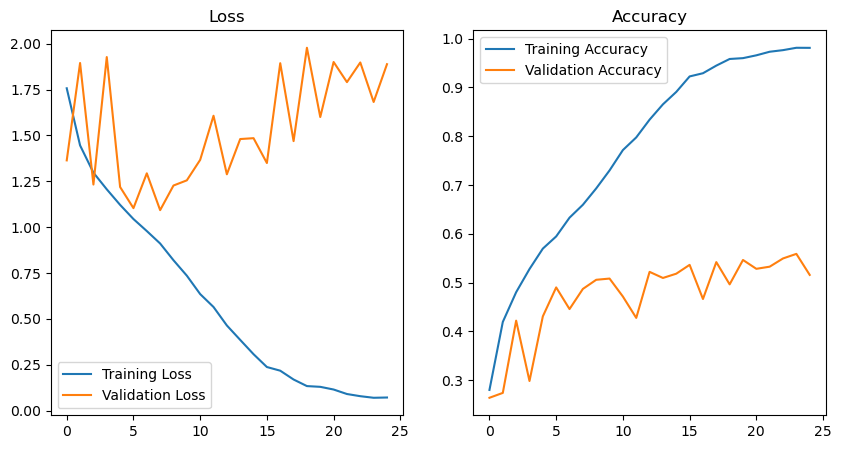

In [26]:
train_accs=torch.tensor(train_accs)
val_accs = torch.tensor(val_accs)  

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Training Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend()

val_accs = val_accs.cpu().numpy()  
axs[1].plot(train_accs, label="Training Accuracy")
axs[1].plot(val_accs, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()

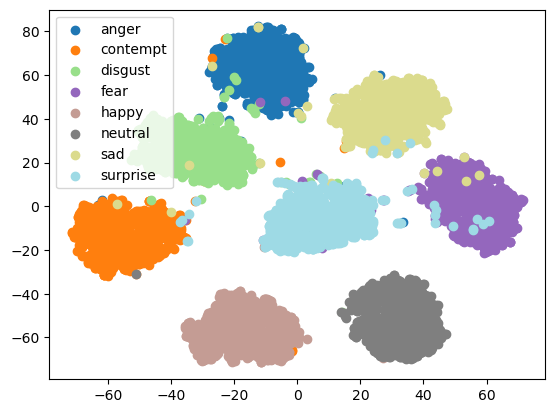

In [27]:
label_names = train_data.class_names
cmap = colormap.get_cmap('tab20',len(label_names))
colors = [cmap(i) for i in range(len(label_names))]
features = []
labels = []

with torch.no_grad():
    for images, target in train_loader:
        images = images.to(device) 
        outputs = best_model(images)
        features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
        labels.append(target.cpu().numpy())
        
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

for label_id in range(len(label_names)):
    mask = (labels == label_id).flatten()
    plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()


100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Test Results:
Test Accuracy: 0.5580

              precision    recall  f1-score   support

           0       0.51      0.23      0.32       250
           1       0.75      0.47      0.58       250
           2       0.46      0.43      0.45       250
           3       0.41      0.59      0.49       250
           4       0.94      0.82      0.88       250
           5       0.76      0.92      0.83       250
           6       0.42      0.43      0.43       250
           7       0.40      0.57      0.47       250

    accuracy                           0.56      2000
   macro avg       0.58      0.56      0.55      2000
weighted avg       0.58      0.56      0.55      2000



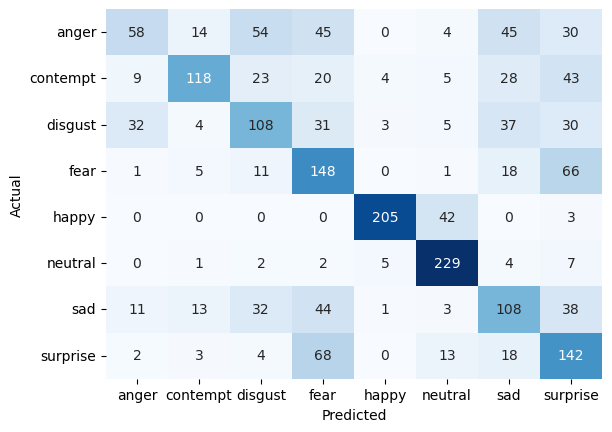

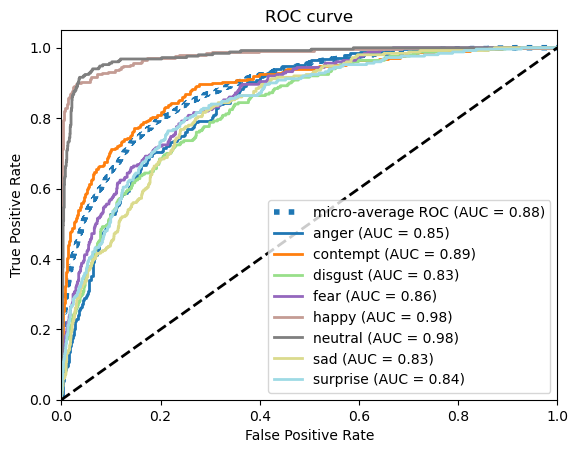

In [28]:
test_model(best_model, test_loader, criterion, device)